# CNCF Landscape: {Category, Subcategory, Project

In [1]:
import os
import pandas as pd
from dotenv import load_dotenv

# load GitHub API Token from .env file
load_dotenv()

True

## Get the current landscape json (array) file

In [2]:
#!wget https://landscape.cncf.io/data/items.json

In [3]:
%%bash 
# array of JSON --> JSONL
jq  -c '.[]' items.json > items.jsonl

## Filter 1200+ cards/entities --> ~180 CNCF Projects --> cncf-projects.jsonl

In [4]:
%%bash
ls -lahF items.jsonl
wc -l items.jsonl

# landscape | select(CNCF Projects) --> cncf-projects.jsonl
jq -c 'select(.relation == "graduated" or .relation == "incubating" or .relation == "sandbox")' items.jsonl > cncf-projects.jsonl 

ls -lahF cncf-projects.jsonl
wc -l cncf-projects.jsonl

-rw-r--r--  1 matt  staff   9.7M Nov 20 15:15 items.jsonl
    2267 items.jsonl
-rw-r--r--  1 matt  staff   3.9M Nov 20 15:15 cncf-projects.jsonl
     178 cncf-projects.jsonl


### DataFrame helpers (safe_set_index(), split_org_repo()

In [5]:
import pandas as pd

pd.set_option('display.max_rows', 512)
pd.set_option('display.max_columns', 512)
pd.set_option('display.width', 512)

def safe_set_index(df:         pd.DataFrame, 
                   idx_wanted: list[str],
                   sort:       bool = True,
                   inplace:    bool = True) -> pd.DataFrame:
    '''check to see if the index is already set, else, data loss as set_index can be destructive'''
    
    idx_existing = list(df.index.names)

    if idx_wanted == idx_existing:
        print(f'\n*** WARNING: attempt to set index to what it already is thwarted! \n')
    else:
        df.set_index(idx_wanted, verify_integrity=True, inplace=inplace)
        print(f'\t Index changed from {idx_existing} --> {list(df.index.names)}') 

    if sort:
        df.sort_index(inplace=inplace)

    return df

def split_org_repo(df:      pd.DataFrame, 
                   colname: str,
                   drop:    bool = False,
                   newcol_org_name:  str = 'org_name',
                   newcol_repo_name: str = 'repo_name') -> pd.DataFrame:
    '''split_org_repo(df, colname) - org_name/repo_name --> org_name, repo_name'''
    
    if colname is None:
        raise ValueError('split_org_repo: missing colname!')

    # https://swdevnotes.com/python/2022/extract-data-from-json-in-pandas-dataframe/
    # expand=True returns a dataframe  which we can rename columns on
    
    df_newcols = df[colname].copy().str.split(pat='/', n=1, expand=True)
    df_newcols.rename(columns={0: newcol_org_name, 1: newcol_repo_name}, inplace=True)

    if drop:
        df.drop(colname, axis=1, inplace=True)

    df = pd.concat([df,df_newcols], axis=1)
    return df

## Load and pre pthe Landscape from cncf-projects.jsonl

In [6]:
file_path = './cncf-projects.jsonl'

if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
    df_projects = pd.read_json(file_path, lines=True)
else:
    print(f"File {file_path} does not exist or is empty.")

print(df_projects.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      178 non-null    object 
 1   homepage_url              178 non-null    object 
 2   project                   178 non-null    object 
 3   repo_url                  176 non-null    object 
 4   logo                      178 non-null    object 
 5   twitter                   174 non-null    object 
 6   crunchbase                178 non-null    object 
 7   extra                     176 non-null    object 
 8   github_data               176 non-null    object 
 9   repos                     176 non-null    object 
 10  github_start_commit_data  176 non-null    object 
 11  image_data                178 non-null    object 
 12  firstCommitDate           176 non-null    object 
 13  firstCommitLink           176 non-null    object 
 14  latestComm

In [7]:
df_projects.head(1)

name          homepage_url  project                              repo_url      logo                          twitter                                         crunchbase                                              extra                                        github_data                                              repos                           github_start_commit_data                                         image_data       firstCommitDate                                    firstCommitLink  \
0  Akri  https://docs.akri.sh  sandbox  https://github.com/project-akri/akri  akri.svg  https://twitter.com/ProjectAkri  https://www.crunchbase.com/organization/cloud-...  {'accepted': '2021-09-14', 'annual_review_date...  {'languages': [{'name': 'Rust', 'value': 10535...  [{'url': 'https://github.com/project-akri/akri...  {'start_commit_link': '/project-akri/akri/comm...  {'fileName': 'akri.svg', 'hash': '2nK42JQaM8qF...  2020-10-14T00:42:19Z  https://github.com/project-akri/akri/commit/94...   

                                    latestCommitDate                                   latestCommitLink                                        releaseDate                                    releaseLink  commitsThisYear  contributorsCount                                   contributorsLink language  stars             license               headquarters                                    latestTweetDate                                   description                              organization  \
0  {'text': '2 months ago', 'value': '950', 'orig...  https://github.com/project-akri/akri/commit/98...  {'text': '7 months ago', 'value': '900', 'orig...  https://github.com/project-akri/akri/releases              197               34.0  https://github.com/project-akri/akri/graphs/co...     Rust  996.0  Apache License 2.0  San Francisco, California  {'text': '7 months ago', 'value': '900', 'orig...  A Kubernetes Resource Interface for the Edge  Cloud Native Computing Foundation (CNCF)   

                                      crunchbaseData                                       path                                  landscape      category amountKind   amount   oss            href  bestPracticeBadgeId  bestPracticePercentage                                         industries  starsPresent starsAsText  marketCapPresent marketCapAsText    id flatName member relation  isSubsidiaryProject  allow_duplicate_repo project_org joined  enduser url_for_bestpractices  open_source second_path  
0  {'name': 'Cloud Native Computing Foundation (C...  Provisioning / Automation & Configuration  Provisioning / Automation & Configuration  Provisioning    funding  3000000  True  logos/akri.svg                 5339                    99.0  [Cloud Computing, Cloud Infrastructure, Non Pr...          True         996              True             $3M  akri     Akri  False  sandbox                False                   NaN         NaN    NaN      NaN                   NaN          NaN         NaN

### cols += { subcategory, repo, org_name, repo_name }

In [8]:
# clean up path to strip out the category (path := category / subcategory)
df_projects['subcategory'] = df_projects['path'].str.split('/').str[-1]

# https://github.com/theOrg/theRepo --> theOrg/theRepo
df_projects['repo'] = df_projects['repo_url'].astype('string').str.removeprefix('https://github.com/')

# theOrg/theRepo --> theOrg, theRepo
df_projects = split_org_repo(df_projects, 'repo')

In [9]:
df_projects.head(3)

name                homepage_url     project                                           repo_url                 logo                             twitter                                         crunchbase                                              extra                                        github_data                                              repos                           github_start_commit_data                                         image_data       firstCommitDate  \
0                        Akri        https://docs.akri.sh     sandbox               https://github.com/project-akri/akri             akri.svg     https://twitter.com/ProjectAkri  https://www.crunchbase.com/organization/cloud-...  {'accepted': '2021-09-14', 'annual_review_date...  {'languages': [{'name': 'Rust', 'value': 10535...  [{'url': 'https://github.com/project-akri/akri...  {'start_commit_link': '/project-akri/akri/comm...  {'fileName': 'akri.svg', 'hash': '2nK42JQaM8qF...  2020-10-14T00:42:19Z   
1  CDK for Kubernetes (CDK8s)           https://cdk8s.io/     sandbox                https://github.com/cdk8s-team/cdk8s            cdk8s.svg  https://twitter.com/CloudNativeFdn  https://www.crunchbase.com/organization/cloud-...  {'accepted': '2020-11-10', 'annual_review_url'...  {'languages': [{'name': 'JavaScript', 'value':...  [{'url': 'https://github.com/cdk8s-team/cdk8s'...  {'start_commit_link': '/cdk8s-team/cdk8s/commi...  {'fileName': 'cdk-for-kubernetes-cdk8s.svg', '...  2019-07-25T12:45:22Z   
2             Cloud Custodian  https://cloudcustodian.io/  incubating  https://github.com/cloud-custodian/cloud-custo...  cloud-custodian.svg  https://twitter.com/CloudNativeFdn  https://www.crunchbase.com/organization/cloud-...  {'accepted': '2020-06-25', 'dev_stats_url': 'h...  {'languages': [{'name': 'Python', 'value': 771...  [{'url': 'https://github.com/cloud-custodian/c...  {'start_commit_link': '/cloud-custodian/cloud-...  {'fileName': 'cloud-custodian.svg', 'hash': '0...  2015-07-16T14:19:15Z   

                                     firstCommitLink                                   latestCommitDate                                   latestCommitLink                                        releaseDate                                        releaseLink  commitsThisYear  contributorsCount                                   contributorsLink    language   stars             license               headquarters                                    latestTweetDate  \
0  https://github.com/project-akri/akri/commit/94...  {'text': '2 months ago', 'value': '950', 'orig...  https://github.com/project-akri/akri/commit/98...  {'text': '7 months ago', 'value': '900', 'orig...      https://github.com/project-akri/akri/releases              197               34.0  https://github.com/project-akri/akri/graphs/co...        Rust   996.0  Apache License 2.0  San Francisco, California  {'text': '7 months ago', 'value': '900', 'orig...   
1  https://github.com/cdk8s-team/cdk8s/commit/ec7...  {'text': 'about a month', 'value': '960', 'ori...  https://github.com/cdk8s-team/cdk8s/commit/6b9...                               2021-10-13T20:21:32Z       https://github.com/cdk8s-team/cdk8s/releases              434               78.0  https://github.com/cdk8s-team/cdk8s/graphs/con...  JavaScript  3818.0  Apache License 2.0  San Francisco, California  {'text': '7 months ago', 'value': '900', 'orig...   
2  https://github.com/cloud-custodian/cloud-custo...  {'text': '2 months ago', 'value': '950', 'orig...  https://github.com/cloud-custodian/cloud-custo...  {'text': '2 months ago', 'value': '950', 'orig...  https://github.com/cloud-custodian/cloud-custo...              522              441.0  https://github.com/cloud-custodian/cloud-custo...      Python  4951.0  Apache License 2.0  San Francisco, California  {'text': '7 months ago', 'value': '900', 'orig...   

                                         description                              organization                                 

## Create a smaller (cleaner) dataframe to work with

In [10]:
# df2=df[['B','D','F']].rename({'B':'X','D':'Y','F':'Z'}, axis=1)
df = df_projects.reset_index()
df = df[[
    'relation',
    'category',
    'subcategory',
    'id',
    'name',
    'flatName',
    'repo',
    'repo_name',
    'org_name',
    'contributorsCount',
    'commitsThisYear',
    'stars',
    'github_data',
    'extra',
    'industries',
    'headquarters',
    'image_data']].copy()

df.head()

relation      category                  subcategory                        id                        name                    flatName                             repo        repo_name         org_name  contributorsCount  commitsThisYear   stars                                        github_data                                              extra                                         industries               headquarters                                         image_data
0     sandbox  Provisioning   Automation & Configuration                      akri                        Akri                        Akri                project-akri/akri             akri     project-akri               34.0              197   996.0  {'languages': [{'name': 'Rust', 'value': 10535...  {'accepted': '2021-09-14', 'annual_review_date...  [Cloud Computing, Cloud Infrastructure, Non Pr...  San Francisco, California  {'fileName': 'akri.svg', 'hash': '2nK42JQaM8qF...
1     sandbox  Provisioning   Automation & Configuration  cdk-for-kubernetes-cdk8s  CDK for Kubernetes (CDK8s)  CDK for Kubernetes (CDK8s)                 cdk8s-team/cdk8s            cdk8s       cdk8s-team               78.0              434  3818.0  {'languages': [{'name': 'JavaScript', 'value':...  {'accepted': '2020-11-10', 'annual_review_url'...  [Cloud Computing, Cloud Infrastructure, Non Pr...  San Francisco, California  {'fileName': 'cdk-for-kubernetes-cdk8s.svg', '...
2  incubating  Provisioning   Automation & Configuration           cloud-custodian             Cloud Custodian             Cloud Custodian  cloud-custodian/cloud-custodian  cloud-custodian  cloud-custodian              441.0              522  4951.0  {'languages': [{'name': 'Python', 'value': 771...  {'accepted': '2020-06-25', 'dev_stats_url': 'h...  [Cloud Computing, Cloud Infrastructure, Non Pr...  San Francisco, California  {'fileName': 'cloud-custodian.svg', 'hash': '0...
3     sandbox  Provisioning   Automation & Configuration                dev-stream                   DevStream                   DevStream           devstream-io/devstream        devstream     devstream-io               62.0              515   815.0  {'languages': [{'name': 'Go', 'value': 31401, ...  {'accepted': '2022-06-17', 'dev_stats_url': 'h...  [Cloud Computing, Cloud Infrastructure, Non Pr...  San Francisco, California  {'fileName': 'dev-stream.svg', 'hash': 'R9wN8R...
4     sandbox  Provisioning   Automation & Configuration                       kcl                         KCL                         KCL                     kcl-lang/kcl              kcl         kcl-lang               15.0              329   808.0  {'languages': [{'name': 'Rust', 'value': 28654...  {'accepted': '2023-09-20', 'dev_stats_url': 'h...  [Cloud Computing, Cloud Infrastructure, Non Pr...  San Francisco, California  {'fileName': 'kcl.svg', 'hash': 'vzDONy6/3IQev...

In [11]:
print(f'before nulls removed: {df.shape}')
df = df.dropna().copy()
print(f'after nulls removed: {df.shape}')

before nulls removed: (178, 17)
after nulls removed: (174, 17)


In [12]:
categories = df['category'].drop_duplicates().tolist()
print(f'CATEGORIES\n{categories}\n')

subcategories = df['subcategory'].drop_duplicates().tolist()
print(f'SUBCATEGORIES\n{subcategories}\n')

org_names = df['org_name'].drop_duplicates().tolist()
print(f'ORG_NAMES\n{org_names}\n')


CATEGORIES
['Provisioning', 'Runtime', 'Orchestration & Management', 'App Definition and Development', 'Platform', 'Serverless', 'Observability and Analysis', 'Wasm']

SUBCATEGORIES
[' Automation & Configuration', ' Container Registry', ' Security & Compliance', ' Key Management', ' Cloud Native Storage', ' Container Runtime', ' Cloud Native Network', ' Scheduling & Orchestration', ' Coordination & Service Discovery', ' Remote Procedure Call', ' Service Proxy', ' API Gateway', ' Service Mesh', ' Database', ' Streaming & Messaging', ' Application Definition & Image Build', ' Continuous Integration & Delivery', ' Certified Kubernetes - Distribution', ' Certified Kubernetes - Installer', ' Framework', ' Installable Platform', ' Monitoring', ' Logging', ' Tracing', ' Chaos Engineering', ' Continuous Optimization', ' Runtimes']

ORG_NAMES
['project-akri', 'cdk8s-team', 'cloud-custodian', 'devstream-io', 'kcl-lang', 'GoogleContainerTools', 'kubedl-io', 'kubeedge', 'meshery', 'metal3-io', 'op

In [13]:
df.head()

relation      category                  subcategory                        id                        name                    flatName                             repo        repo_name         org_name  contributorsCount  commitsThisYear   stars                                        github_data                                              extra                                         industries               headquarters                                         image_data
0     sandbox  Provisioning   Automation & Configuration                      akri                        Akri                        Akri                project-akri/akri             akri     project-akri               34.0              197   996.0  {'languages': [{'name': 'Rust', 'value': 10535...  {'accepted': '2021-09-14', 'annual_review_date...  [Cloud Computing, Cloud Infrastructure, Non Pr...  San Francisco, California  {'fileName': 'akri.svg', 'hash': '2nK42JQaM8qF...
1     sandbox  Provisioning   Automation & Configuration  cdk-for-kubernetes-cdk8s  CDK for Kubernetes (CDK8s)  CDK for Kubernetes (CDK8s)                 cdk8s-team/cdk8s            cdk8s       cdk8s-team               78.0              434  3818.0  {'languages': [{'name': 'JavaScript', 'value':...  {'accepted': '2020-11-10', 'annual_review_url'...  [Cloud Computing, Cloud Infrastructure, Non Pr...  San Francisco, California  {'fileName': 'cdk-for-kubernetes-cdk8s.svg', '...
2  incubating  Provisioning   Automation & Configuration           cloud-custodian             Cloud Custodian             Cloud Custodian  cloud-custodian/cloud-custodian  cloud-custodian  cloud-custodian              441.0              522  4951.0  {'languages': [{'name': 'Python', 'value': 771...  {'accepted': '2020-06-25', 'dev_stats_url': 'h...  [Cloud Computing, Cloud Infrastructure, Non Pr...  San Francisco, California  {'fileName': 'cloud-custodian.svg', 'hash': '0...
3     sandbox  Provisioning   Automation & Configuration                dev-stream                   DevStream                   DevStream           devstream-io/devstream        devstream     devstream-io               62.0              515   815.0  {'languages': [{'name': 'Go', 'value': 31401, ...  {'accepted': '2022-06-17', 'dev_stats_url': 'h...  [Cloud Computing, Cloud Infrastructure, Non Pr...  San Francisco, California  {'fileName': 'dev-stream.svg', 'hash': 'R9wN8R...
4     sandbox  Provisioning   Automation & Configuration                       kcl                         KCL                         KCL                     kcl-lang/kcl              kcl         kcl-lang               15.0              329   808.0  {'languages': [{'name': 'Rust', 'value': 28654...  {'accepted': '2023-09-20', 'dev_stats_url': 'h...  [Cloud Computing, Cloud Infrastructure, Non Pr...  San Francisco, California  {'fileName': 'kcl.svg', 'hash': 'vzDONy6/3IQev...

In [14]:
df = safe_set_index(df, idx_wanted=['relation', 'category', 'subcategory', 'id'])
df

	 Index changed from [None] --> ['relation', 'category', 'subcategory', 'id']


name                             flatName                                               repo                 repo_name                    org_name  contributorsCount  commitsThisYear     stars                                        github_data                                              extra                                         industries  \
relation   category                       subcategory                           id                                                                                                                                                                                                                                                                                                                                                                                                                              
graduated  App Definition and Development  Application Definition & Image Build helm                                                                Helm                                 Helm                                          helm/helm                      helm                        helm              766.0              407   24953.0  {'languages': [{'name': 'Go', 'value': 1807584...  {'accepted': '2018-06-01', 'incubating': '2018...  [Cloud Computing, Cloud Infrastructure, Non Pr...   
                                           Continuous Integration & Delivery    argo                                                                Argo                                 Argo                                   argoproj/argo-cd                   argo-cd                    argoproj             1154.0             1338   14145.0  {'languages': [{'name': 'Go', 'value': 5524117...  {'accepted': '2020-03-26', 'incubating': '2020...  [Cloud Computing, Cloud Infrastructure, Non Pr...   
                                                                                flux                                                                Flux                                 Flux                                       fluxcd/flux2                     flux2                      fluxcd              140.0              689    5300.0  {'languages': [{'name': 'Go', 'value': 970748,...  {'accepted': '2019-07-15', 'incubating': '2021...  [Cloud Computing, Cloud Infrastructure, Non Pr...   
                                           Database                             ti-kv                                                               TiKV                                 TiKV                                          tikv/tikv                      tikv                        tikv              412.0              690   13617.0  {'languages': [{'name': 'Rust', 'value': 21095...  {'accepted': '2018-08-28', 'incubating': '2018...  [Cloud Computing, Cloud Infrastructure, Non Pr...   
                                                                                vitess                                                            Vitess                               Vitess                                    vitessio/vitess                    vitess                    vitessio              379.0             2283   16897.0  {'languages': [{'name': 'Go', 'value': 2680572...  {'accepted': '2018-02-05', 'incubating': '2018...  [Cloud Computing, Cloud Infrastructure, Non Pr...   
           Observability and Analysis      Logging                              fluentd                                                          Fluentd                              Fluentd                                     fluent/fluentd                   fluentd                      fluent              261.0              220   12199.0  {'languages': [{'name': 'Ruby', 'value': 32604...  {'accepted': '2016-11-08', 'incubating': '2016...  [Cloud Computing, Cloud Infrastructure, Non Pr...   
                                           Monitoring                           prometheus                                                    Prometheus                    

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 174 entries, ('graduated', 'App Definition and Development', ' Application Definition & Image Build', 'helm') to ('sandbox', 'Wasm', ' Runtimes', 'wasm-edge-wasm')
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               174 non-null    object 
 1   flatName           174 non-null    object 
 2   repo               174 non-null    string 
 3   repo_name          174 non-null    string 
 4   org_name           174 non-null    string 
 5   contributorsCount  174 non-null    float64
 6   commitsThisYear    174 non-null    int64  
 7   stars              174 non-null    float64
 8   github_data        174 non-null    object 
 9   extra              174 non-null    object 
 10  industries         174 non-null    object 
 11  headquarters       174 non-null    object 
 12  image_data         174 non-null    object 
dtypes: float64(2), int64(1), obj

In [16]:
df.describe()

contributorsCount  commitsThisYear          stars
count         174.000000       174.000000     174.000000
mean          227.632184       806.224138    6024.247126
std           444.918882      1560.983306   10903.482134
min             6.000000         0.000000       8.000000
25%            38.250000       125.250000     809.000000
50%            91.000000       357.500000    1987.500000
75%           259.500000       790.500000    6258.500000
max          4842.000000     12533.000000  101881.000000

In [17]:
df.index

MultiIndex([('graduated', 'App Definition and Development', ' Application Definition & Image Build',                     'helm'),
            ('graduated', 'App Definition and Development',    ' Continuous Integration & Delivery',                     'argo'),
            ('graduated', 'App Definition and Development',    ' Continuous Integration & Delivery',                     'flux'),
            ('graduated', 'App Definition and Development',                             ' Database',                    'ti-kv'),
            ('graduated', 'App Definition and Development',                             ' Database',                   'vitess'),
            ('graduated',     'Observability and Analysis',                              ' Logging',                  'fluentd'),
            ('graduated',     'Observability and Analysis',                           ' Monitoring',               'prometheus'),
            ('graduated',     'Observability and Analysis',                              '

In [18]:
# index --> ['relation', 'category', 'subcategory', 'id']

df_numeric = df.select_dtypes(include=['int64', 'float64'])
df_numeric

contributorsCount  commitsThisYear     stars
relation   category                       subcategory                           id                                                                               
graduated  App Definition and Development  Application Definition & Image Build helm                                             766.0              407   24953.0
                                           Continuous Integration & Delivery    argo                                            1154.0             1338   14145.0
                                                                                flux                                             140.0              689    5300.0
                                           Database                             ti-kv                                            412.0              690   13617.0
                                                                                vitess                                           379.0             2283   16897.0
           Observability and Analysis      Logging                              fluentd                                          261.0              220   12199.0
                                           Monitoring                           prometheus                                       973.0             1135   49987.0
                                           Tracing                              jaeger                                           293.0              404   18318.0
           Orchestration & Management      Coordination & Service Discovery     core-dns                                         370.0              341   11071.0
                                                                                etcd                                             968.0             1761   44537.0
                                           Scheduling & Orchestration           keda                                             302.0              396    6831.0
                                                                                kubernetes                                      4842.0             7549  101881.0
                                           Service Mesh                         istio                                           1121.0             2473   33694.0
                                                                                linkerd                                          330.0             1122    9881.0
                                           Service Proxy                        envoy                                           1216.0             3695   22759.0
           Provisioning                    Container Registry                   harbor                                           347.0              442   20890.0
                                           Key Management                       spiffe                                            56.0               19    1213.0
                                                                                spire                                            153.0              737    1392.0
                                           Security & Compliance                open-policy-agent-opa                            420.0              592    8496.0
                                                                                the-update-framework-tuf                          97.0              554    1541.0
           Runtime                         Cloud Native Network                 cilium                                           749.0             5064   16516.0
                                           Cloud Native Storage                 rook                                             694.0             1313   11830.0
                                           Container Runtime                    containerd                                       611.0             1631   14857.0
                                                                   

In [19]:
# Aggregation at level 0
df_level0_relation = df_numeric.groupby(level=0).sum()  # or .mean(), .count(), etc.

# Aggregation at level 1
df_level1_category = df_numeric.groupby(level=1).sum()  # or .mean(), .count(), etc.

# Aggregation at level 2
df_level2_subcategory = df_numeric.groupby(level=2).sum()  # or .mean(), .count(), etc.

# Aggregation at level 3
# df_level3 = df.groupby(level=3).sum()  # or .mean(), .count(), etc.

In [20]:
print(f'Aggregations at df_level0_relation\n\n{df_level0_relation}\n')
print(f'Aggregations at df_level1_category\n\n{df_level1_category}\n')
print(f'Aggregations at df_level2_subcategory\n\n{df_level2_subcategory}\n')

Aggregations at df_level0_relation

            contributorsCount  commitsThisYear     stars
relation                                                
graduated             17259.0            36282  474390.0
incubating            12470.0            45996  302281.0
sandbox                9879.0            58005  271548.0

Aggregations at df_level1_category

                                contributorsCount  commitsThisYear     stars
category                                                                    
App Definition and Development             8403.0            36557  213759.0
Observability and Analysis                 3566.0            10537  134514.0
Orchestration & Management                14573.0            41795  346088.0
Platform                                    228.0              654   24740.0
Provisioning                               7137.0            27931  171894.0
Runtime                                    4633.0            20067  111534.0
Serverless                

In [21]:
# print(f'df.index.names: {df.index.names}\n\n')
# #print(f'df.index.levels: {df.index.levels}\n\n')

# for level in df.index.levels:
#     print(f'level: {level}\n')

## Generate Sunbursts and Treemaps for { Contributors Count, Commits this year, Stars }

### Helpers

In [22]:
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go

In [23]:
# Light to Dark Transition:
# color_discrete_map={'sandbox': '#ADD8E6', 'incubating': '#87CEEB', 'graduated': '#000080'}
#
# sandbox: Light Blue (#ADD8E6)
# incubating: Medium Blue (#87CEEB)
# graduated: Dark Blue (#000080)

# Warm to Cool Transition:
# color_discrete_map={'sandbox': '#FFA500', 'incubating': '#FFD700', 'graduated': '#008000'}
#
# sandbox: Orange (#FFA500)
# incubating: Yellow (#FFD700)
# graduated: Green (#008000)

# Warm to Cool 2 Transition:
# color_discrete_map={'sandbox': '#FFD700', 'incubating': '#87CEEB', 'graduated': '#008000'}
#
# sandbox: Yellow (#FFD700)
# incubating: Medium Blue (#87CEEB)
# graduated: Green (#008000)



def create_figure(plotly_func,
                  df,
                  values=None,
                  height: int = 1200,
                  width: int = 1200,
                  title: str = 'Missing Title',
                  path=['relation', 'category', 'subcategory', 'id'],
                  color='relation',
                  color_discrete_map={'sandbox': '#FFD700', 'incubating': '#87CEEB', 'graduated': '#008000'},
                  branchvalues: str = None) -> go.Figure:
    
    fig = plotly_func(data_frame=df,
                      values=values,
                      height=height,
                      width=width,
                      title=title,
                      path=path,
                      color=color,
                      color_discrete_map=color_discrete_map,
                      branchvalues='total')
    return fig


def create_sunburst(df, **kwargs) -> go.Figure:
    return create_figure(px.sunburst, df, **kwargs)


def create_treemap(df, **kwargs) -> go.Figure:
    return create_figure(px.treemap, df, **kwargs)

### Create Figures (Sunbursts, Treemaps) 

In [24]:
# make index columns accessible for charting as normal columns
df_reset = df.reset_index()

figs = {}

sunb_contributorsCount = create_sunburst(df_reset, values='contributorsCount', title='sunburst: 🪴 Contributor Count (NOT UNIQUE ACROSS PROJECTS!) 🪴')
sunb_commitsThisYear   = create_sunburst(df_reset, values='commitsThisYear',   title='sunburst: 📄 Commits This Year 📄')
sunb_stars             = create_sunburst(df_reset, values='stars',             title='sunburst: ⭐ Stars ⭐')

tree_contributorsCount = create_treemap(df_reset, values='contributorsCount',  title='treemap: 🪴 Contributor Count (NOT UNIQUE ACROSS PROJECTS!) 🪴')
tree_commitsThisYear   = create_treemap(df_reset, values='commitsThisYear',    title='treemap: 📄 Commits This Year 📄')
tree_stars             = create_treemap(df_reset, values='stars',              title='treemap: ⭐ Stars ⭐')

figs['sunb_contributorsCount'] = sunb_contributorsCount
figs['sunb_commitsThisYear']   = sunb_commitsThisYear
figs['sunb_stars']             = sunb_stars

figs['tree_contributorsCount'] = tree_contributorsCount
figs['tree_commitsThisYear']   = tree_commitsThisYear
figs['tree_stars']             = tree_stars

### Save figures as .svg files

In [25]:
for key, fig in figs.items():
    file_name = f'fig_{key}.svg'
    fig.write_image(file_name, format='svg')

    # Emit raw markdown for image description
    markdown = f"![Image description]({file_name})"
    print(f"```{markdown}```")

```![Image description](fig_sunb_contributorsCount.svg)```
```![Image description](fig_sunb_commitsThisYear.svg)```
```![Image description](fig_sunb_stars.svg)```
```![Image description](fig_tree_contributorsCount.svg)```
```![Image description](fig_tree_commitsThisYear.svg)```
```![Image description](fig_tree_stars.svg)```


In [26]:
# save --> files so viewable in markdown cells
#
# ![Image description](path_to_image.png)

### Display Sunbursts

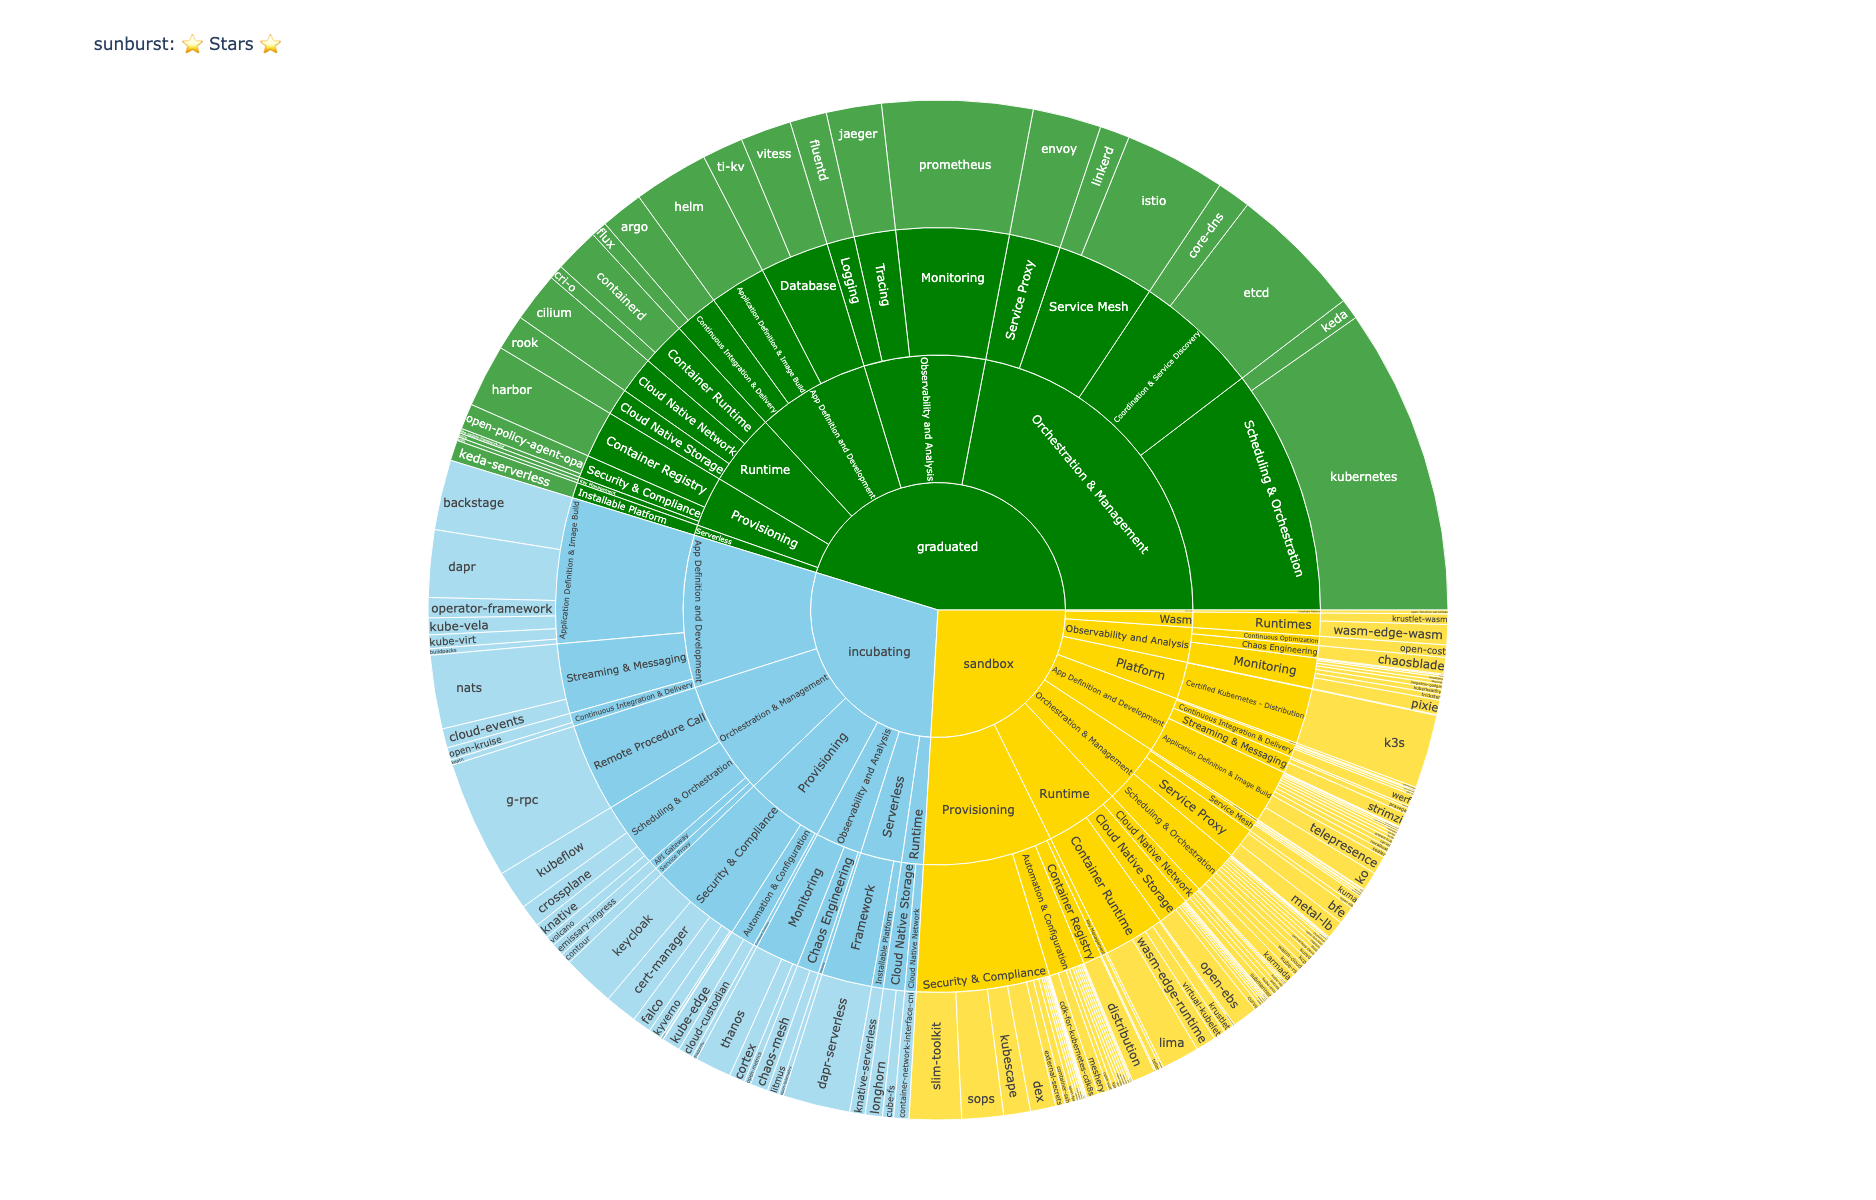

In [27]:
figs['sunb_stars'].show()

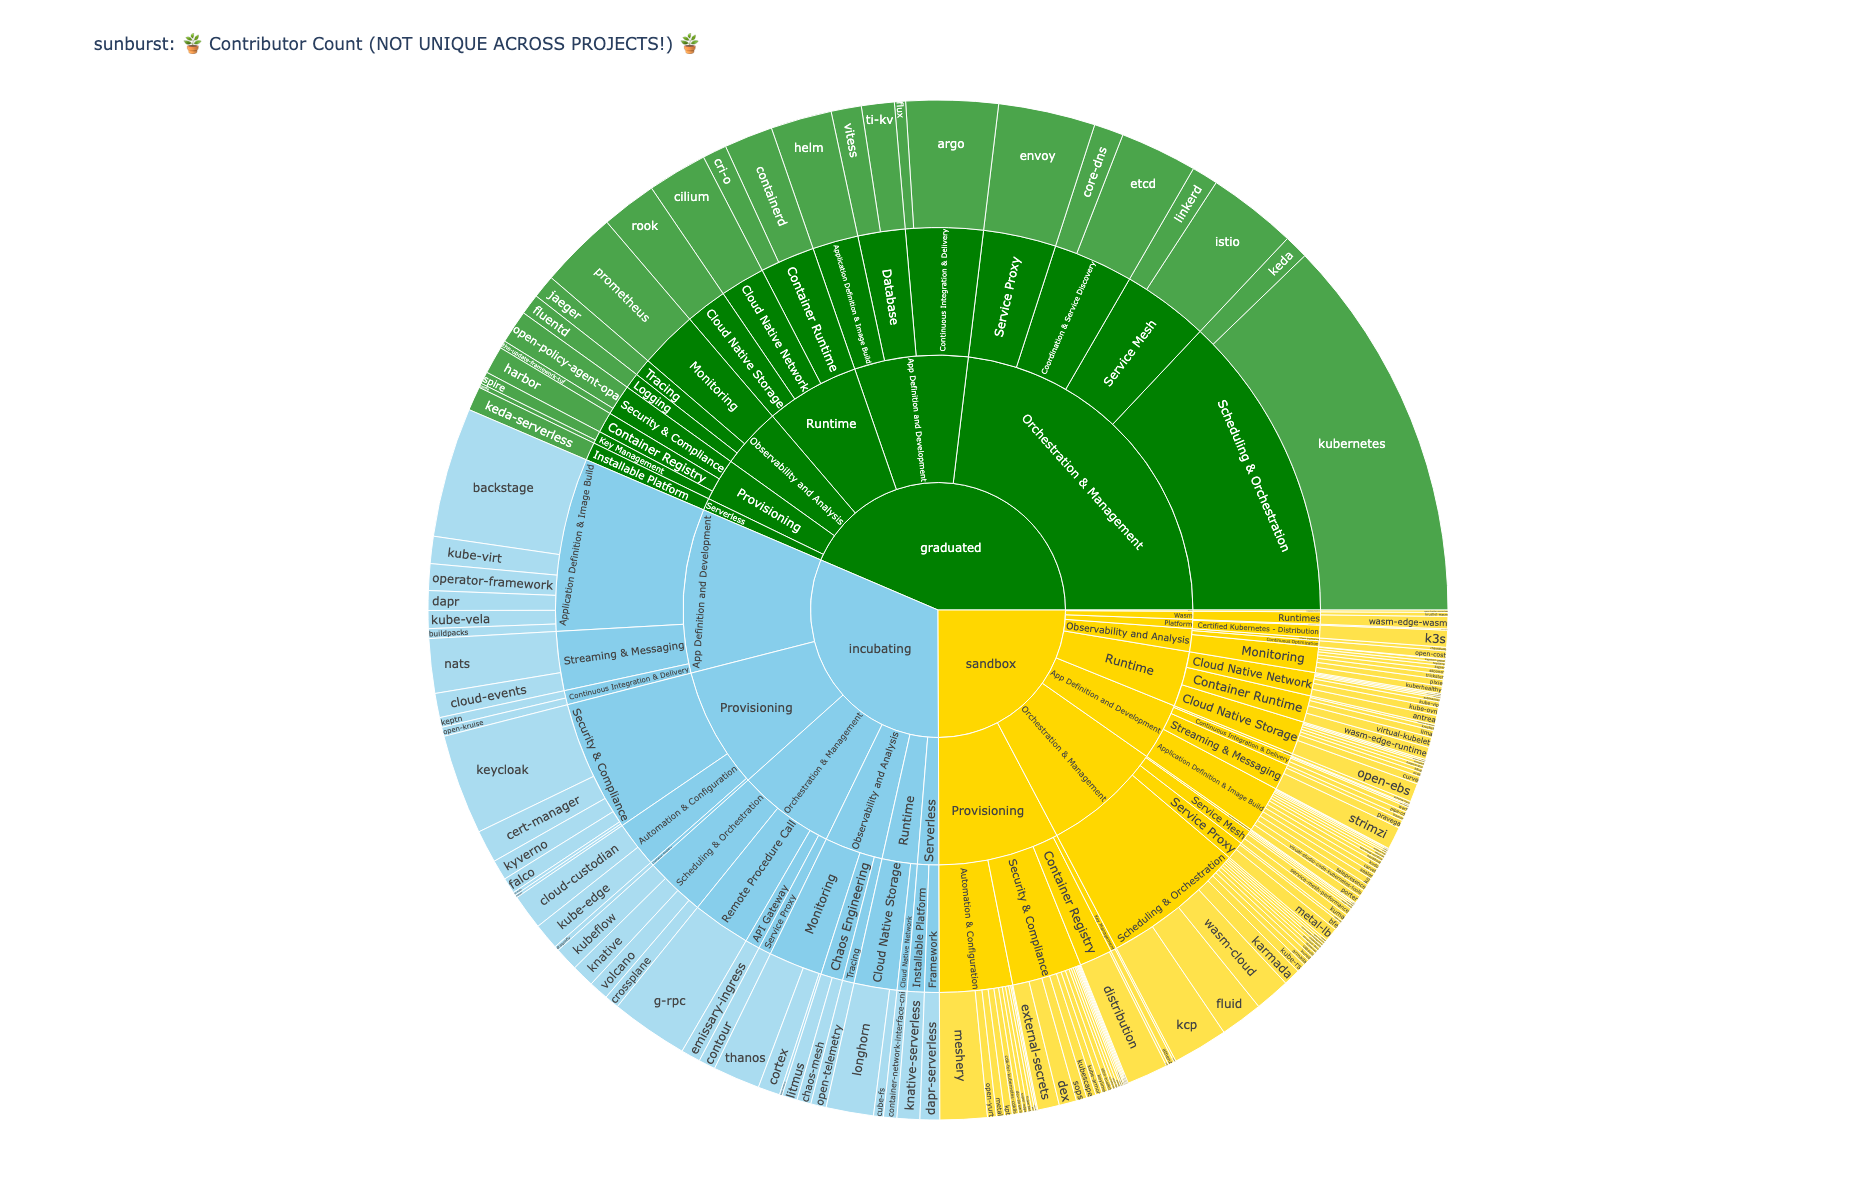

In [28]:
figs['sunb_contributorsCount'].show()

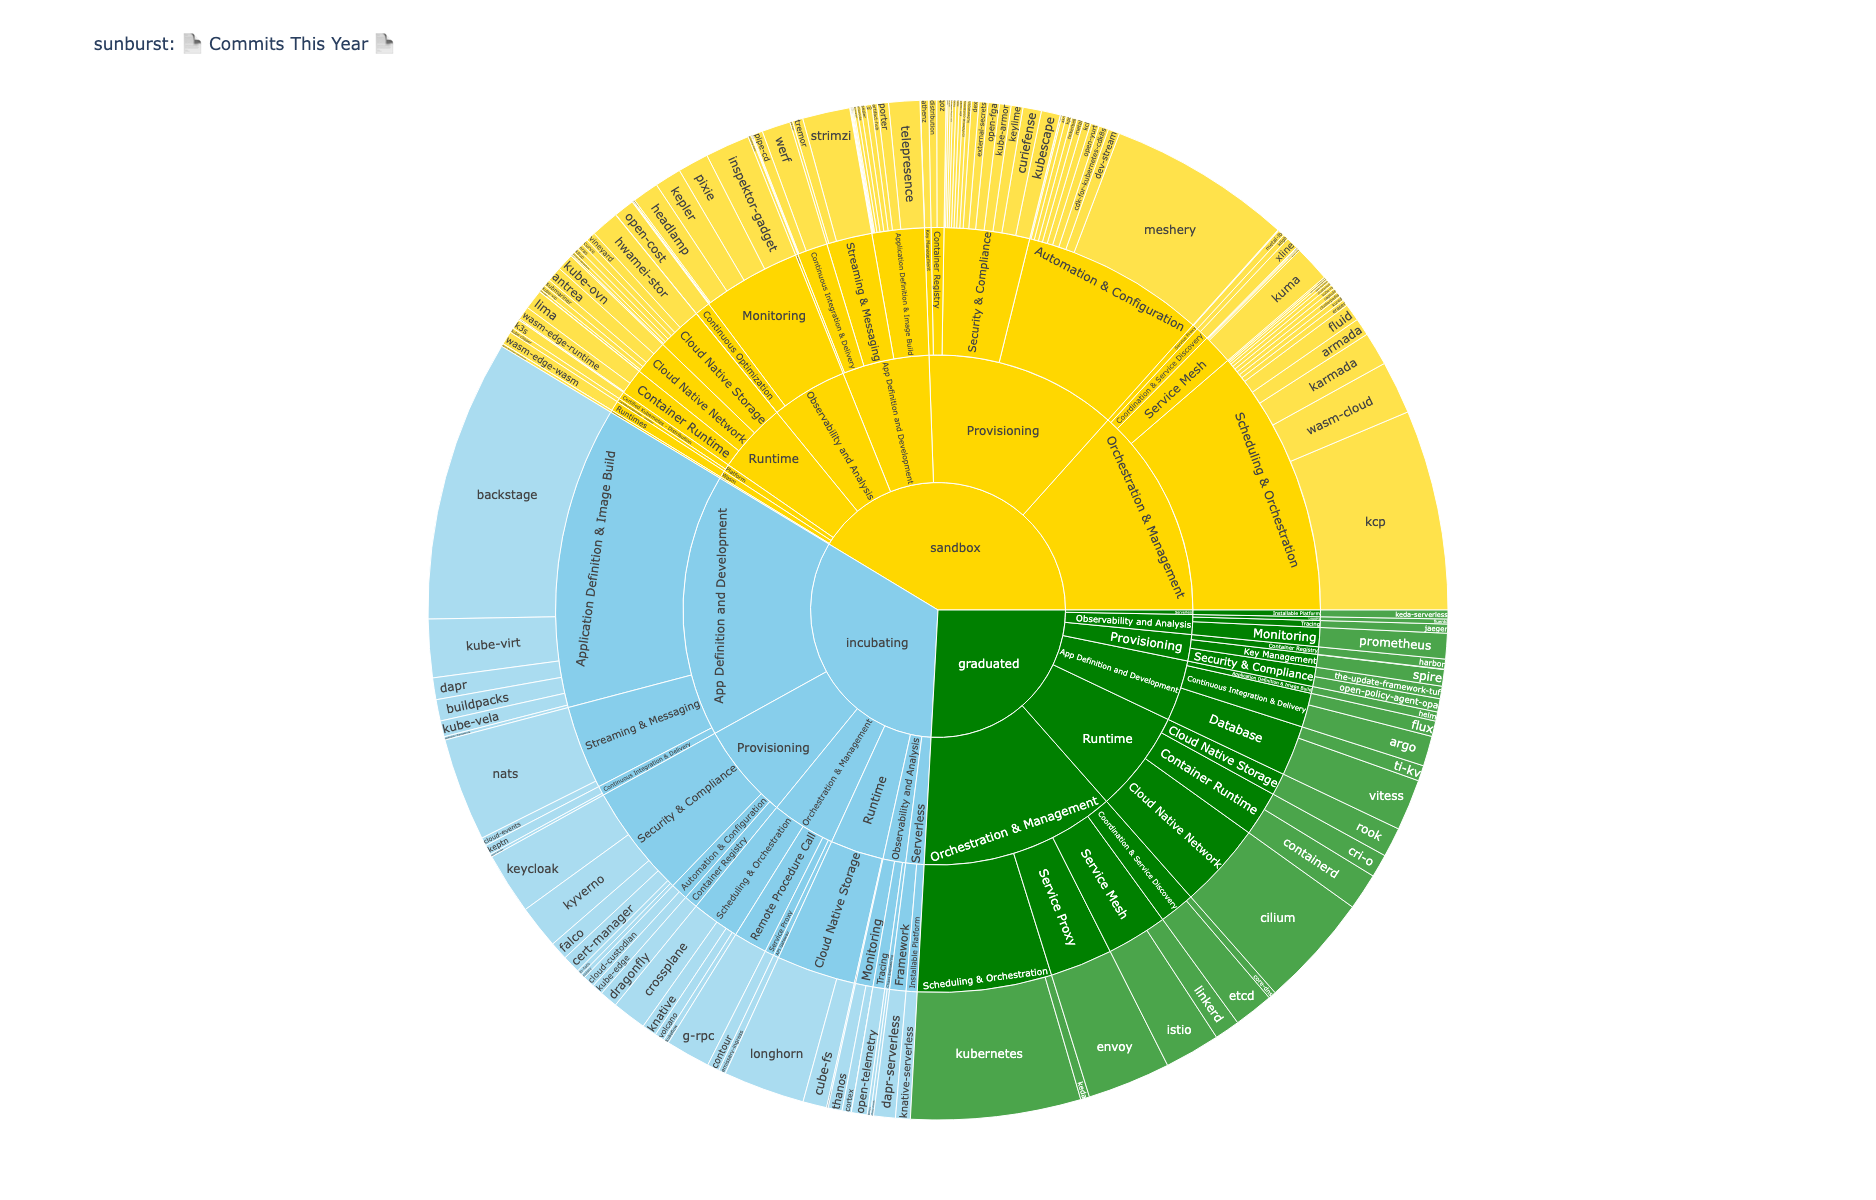

In [29]:
figs['sunb_commitsThisYear'].show()

### Display Treemaps

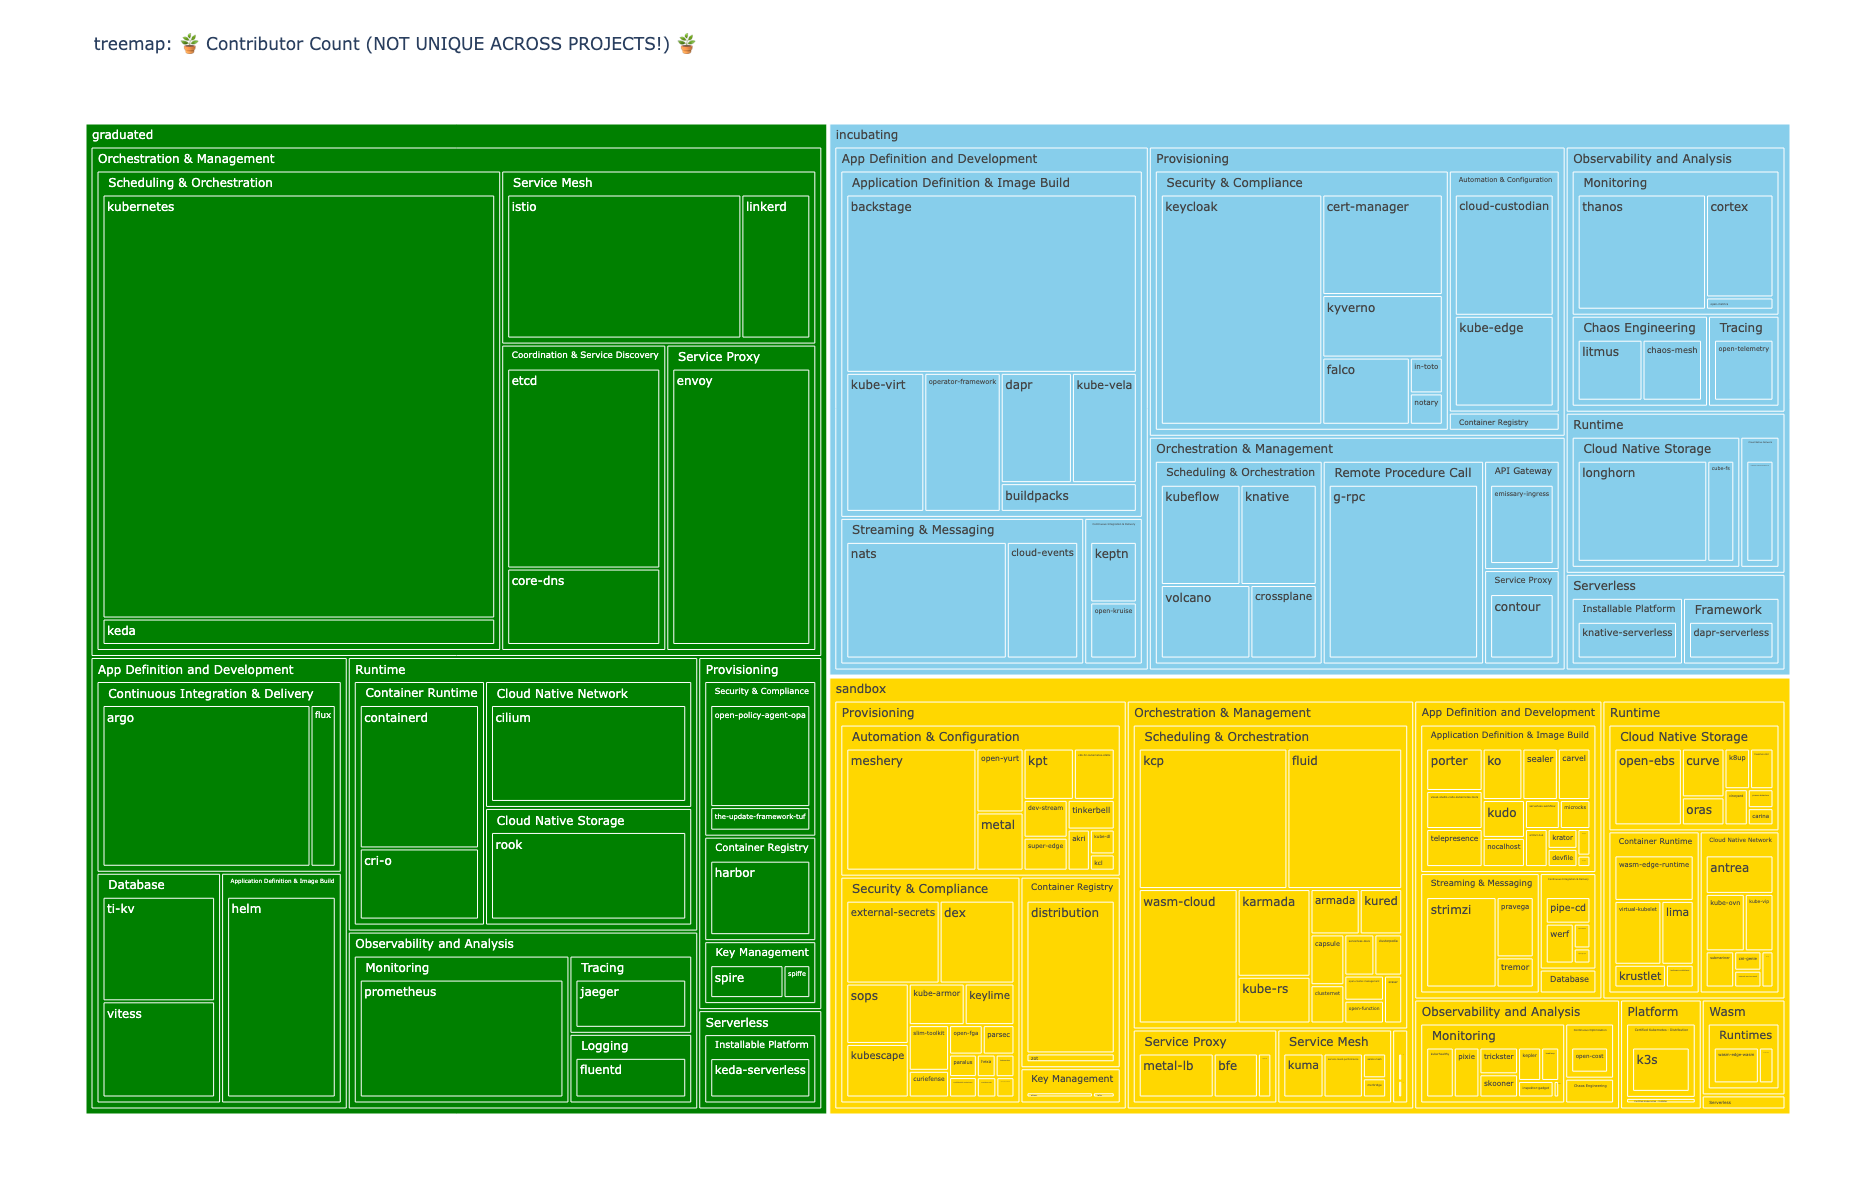

In [30]:
figs['tree_contributorsCount'].show()

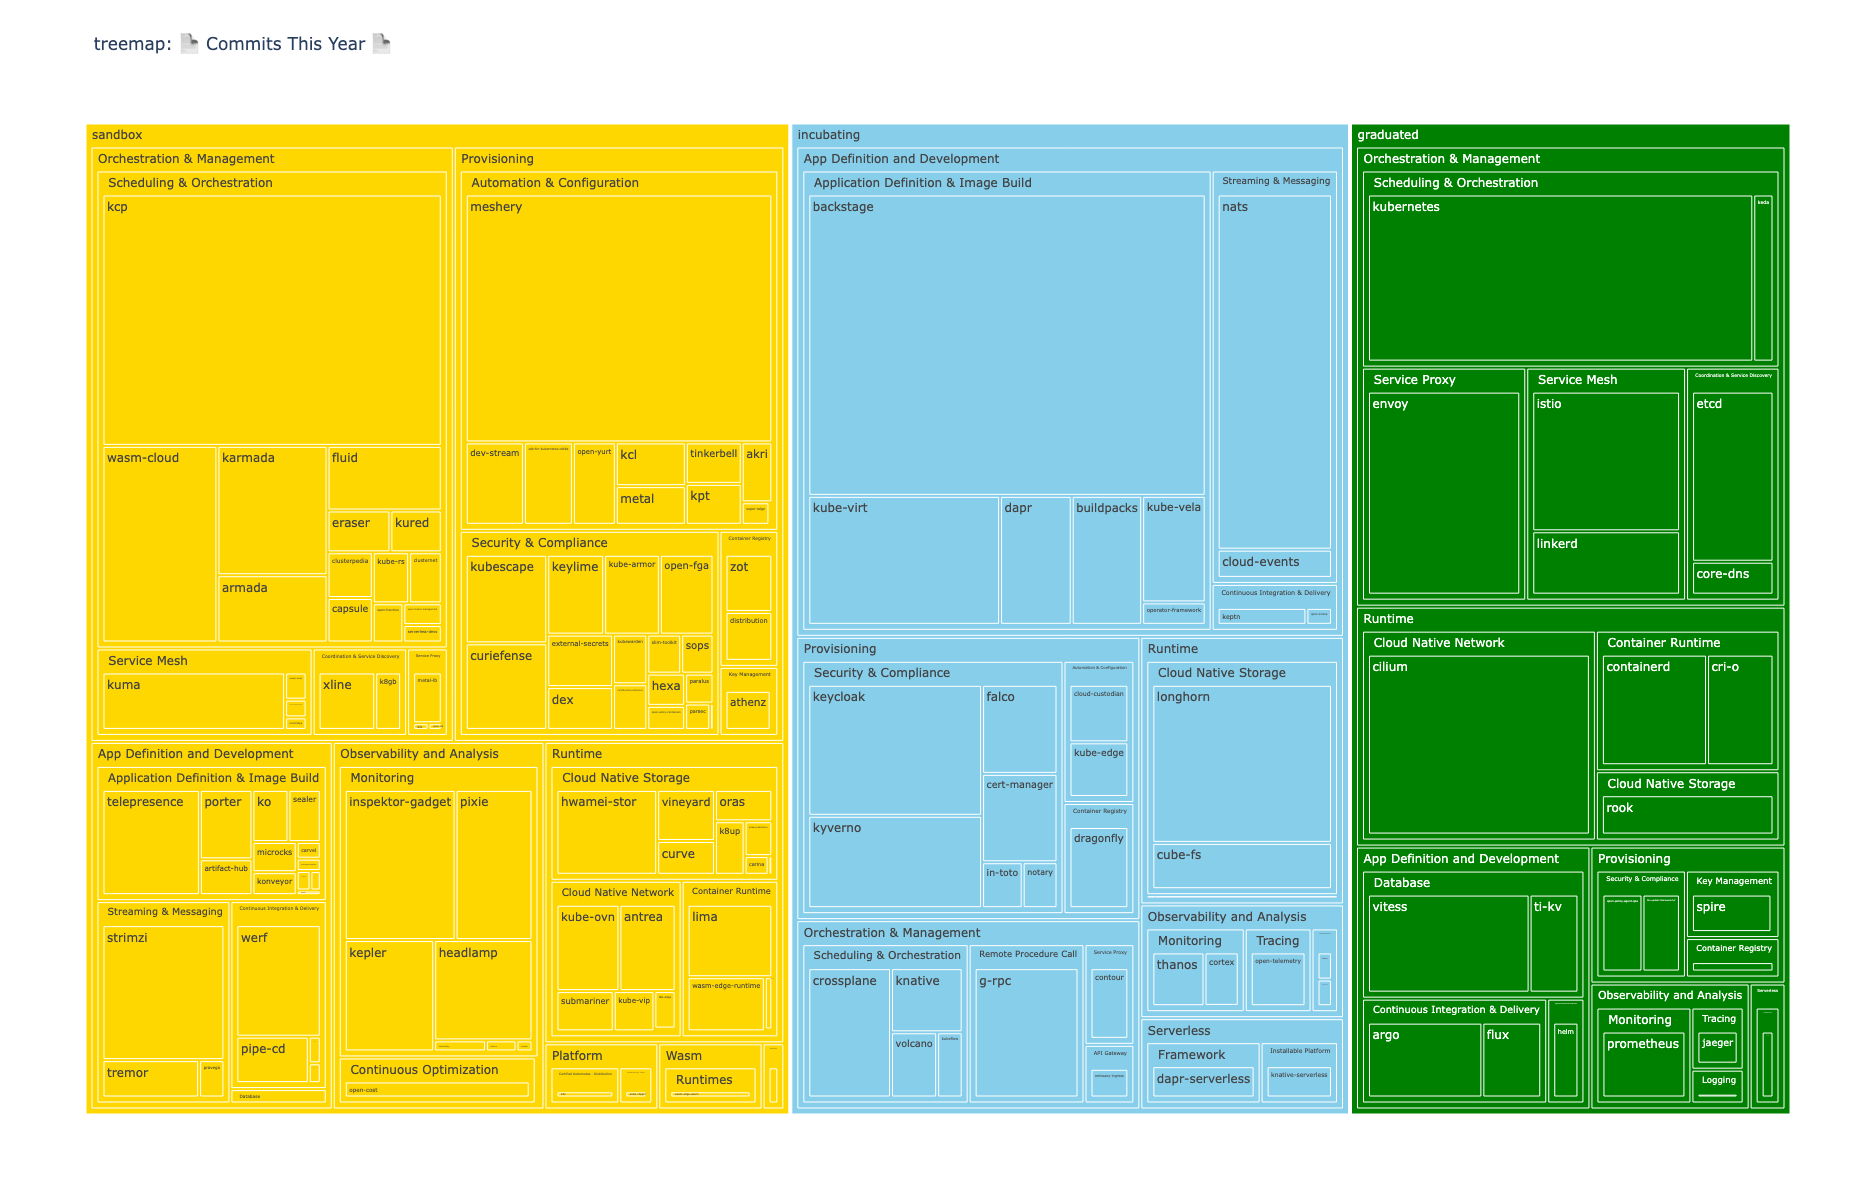

In [31]:
figs['tree_commitsThisYear'].show()

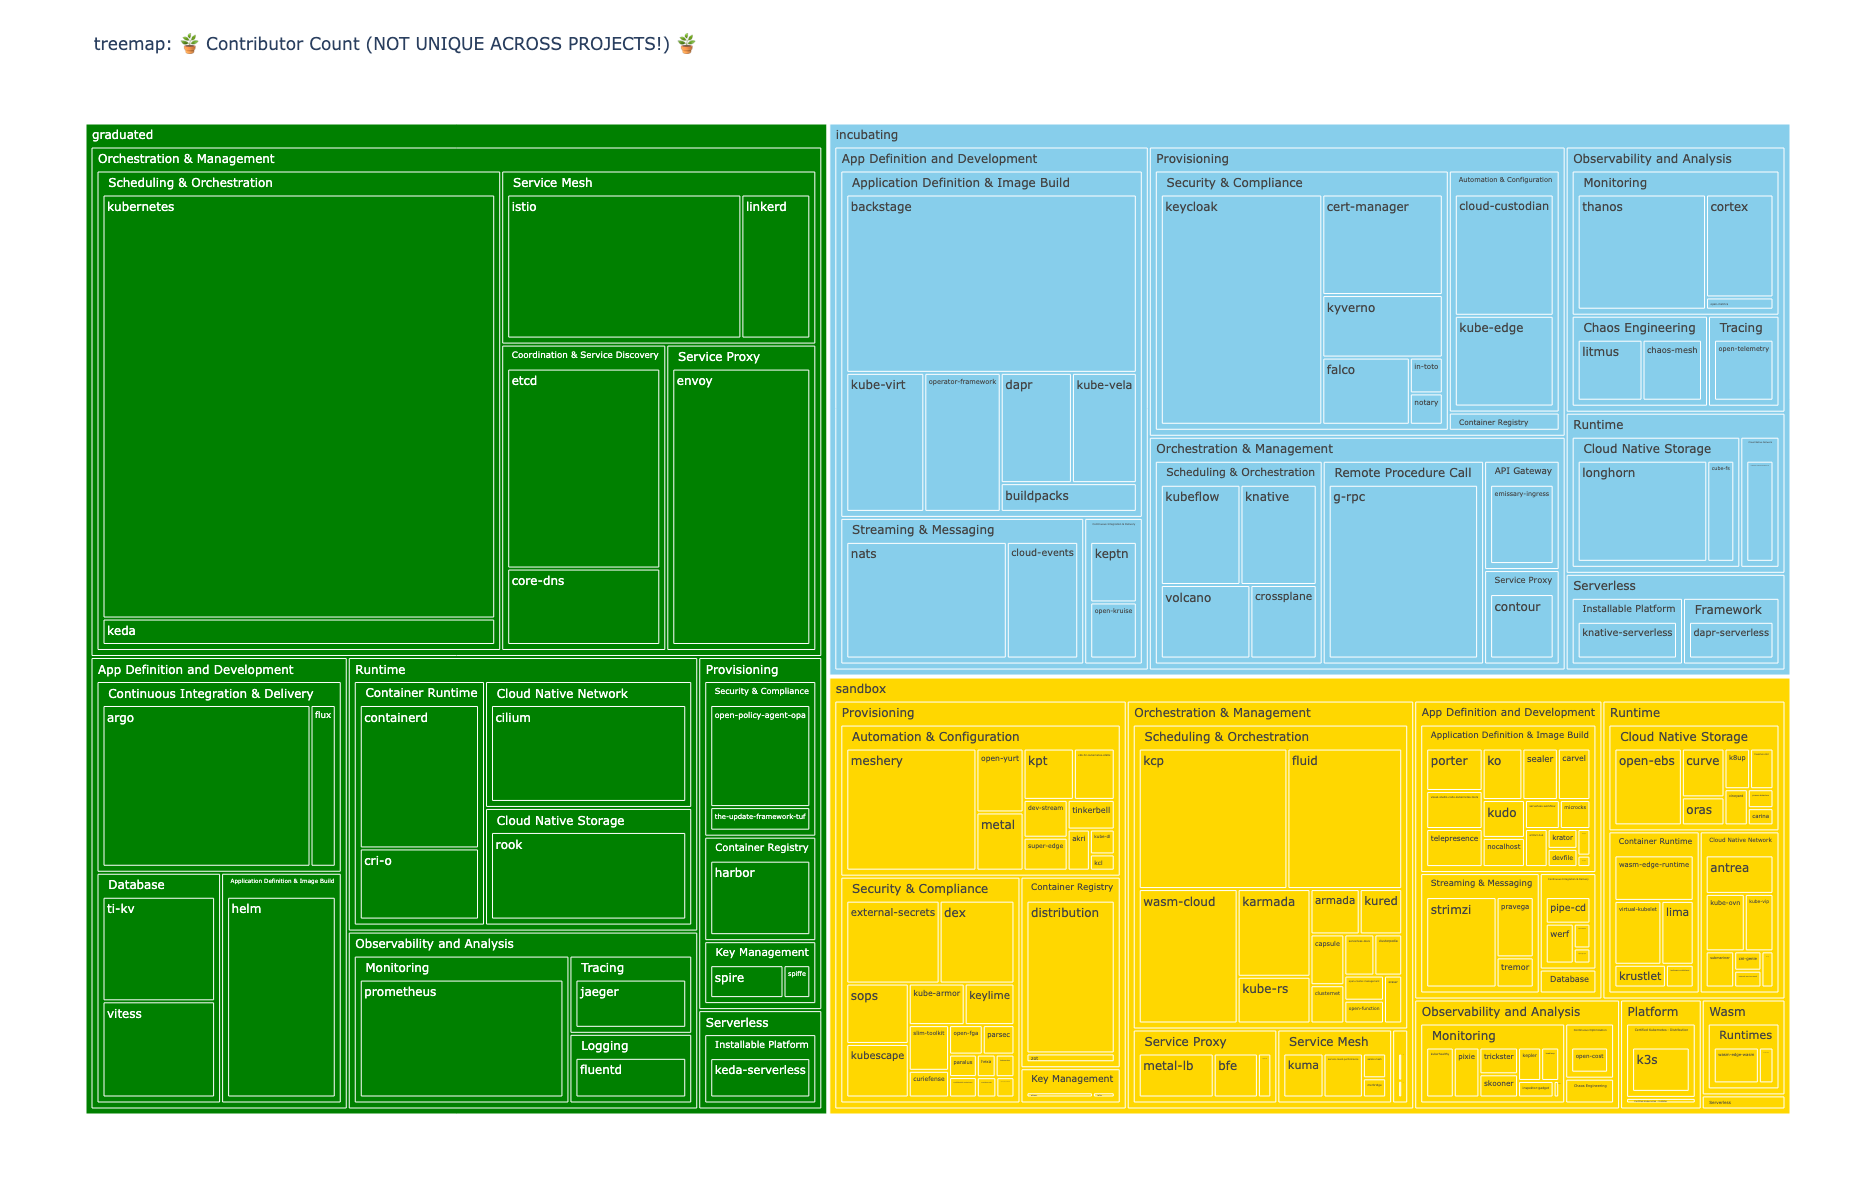

In [32]:
figs['tree_contributorsCount'].show()

### images for github rendering

![Image description](fig_sunb_contributorsCount.svg)
![Image description](fig_sunb_commitsThisYear.svg)
![Image description](fig_sunb_stars.svg)
![Image description](fig_tree_contributorsCount.svg)
![Image description](fig_tree_commitsThisYear.svg)
![Image description](fig_tree_stars.svg)

## Generate Per TAG views.

In [33]:
# debug - just Observability TAG Projects
#repos_by_relation = df.query("`category` == 'Observability and Analysis'")[['relation','repo', 'name']].copy()

repos_by_relation = df[['relation','repo', 'name']].copy()
repos_by_relation.groupby('relation')['repo'].agg(lambda x: list(x)).to_dict()

safe_set_index(repos_by_relation, idx_wanted=['relation', 'name'])
repos_by_relation.sort_index()

KeyError: "['relation'] not in index"

In [ ]:
graduated_single_repos  = repos_by_relation.loc['graduated', :]['repo'].tolist()
incubating_single_repos = repos_by_relation.loc['incubating', :]['repo'].tolist()
sandbox_single_repos    = repos_by_relation.loc['sandbox', :]['repo'].tolist()

display(graduated_single_repos, incubating_single_repos, sandbox_single_repos)

## Fetch project release data from GitHub API

In [ ]:
import time
import os
import json
import pandas as pd
from typing import List
from datetime import datetime, timezone
from github import Github, GithubException

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

def fetch_repo_data(token: str, 
                    repo_list: List[str], 
                    since: datetime=None, 
                    json_file: str=None, 
                    csv_file: str=None, 
                    state_file: str=None) -> pd.DataFrame:

    # Initialize DataFrame
    # df = pd.DataFrame(columns=[
    #     'repo_name', 'release_name', 'release_date', 
    #     'language', 'release_notes'
    # ])

    df = pd.DataFrame(columns=['repo_name', 'release_name', 'release_date', 'language'])

    # Initialize GitHub client
    g = Github(token)

    # Initialize loop state
    if state_file:
        try:
            with open(state_file, 'r') as f:
                state = json.load(f)
        except FileNotFoundError:
            state = {'i': 0, 'repos_done': []}
    else:
        state = {'i': 0, 'repos_done': []}

    # Loop over repositories
    while state['i'] < len(repo_list):
        repo_str = repo_list[state['i']]

        if repo_str in state['repos_done']:
            print(f"Skipping: {repo_str}")
            state['i'] += 1
            continue

        while True:
            try:
                repo = g.get_repo(repo_str)
                break
            except GithubException as e:
                if e.status == 404:
                    print(f"Repository {repo_str} not found")
                    break
                elif e.status == 429:
                    print(f"Rate limit exceeded, waiting for {e.headers['Retry-After']} seconds...")
                    time.sleep(int(e.headers['Retry-After']))
                else:
                    print(f"Error getting repository {repo_str}: {e}")
                    break

        if not repo:
            state['i'] += 1
            continue

        #
        # Get all releases
        #
        releases = repo.get_releases()
        language = repo.language

        for release in releases:
            if since is None or release.created_at >= since:
                df = pd.concat([df, pd.DataFrame({
                    'repo_name': [repo_str],
                    'release_name': [release.title],
                    'release_date': [str(release.published_at)],
                    'language': [language],
                    #'release_notes': [release.body]
                })])
                print(f"Added {release.published_at}, {repo_str}::{release.title}  ")

        # Save state
        if state_file:
            state['repos_done'].append(repo_str)
            with open(state_file, 'w') as f:
                json.dump(state, f, indent=4)

        state['i'] += 1

    #print (releases)
    
    # Save as CSV
    if csv_file:
        df.to_csv(csv_file, index=False)

    # Save as JSON
    if json_file:
        df.to_json(json_file, orient='records', lines=True)
    return df

In [ ]:
!mkdir -p out

In [ ]:
def fetch_one(token, since_date, level, repos):

    json_file=f'out/{level}-github-releases.json' 
    csv_file=f'out/{level}-github-releases.csv'
    state_file=f'out/.nukeme_state_file_{level}'
    
    print(f"Fetching {len(repos)} repositories for {level} projects")
    
    releases = fetch_repo_data( token, 
                                repos, 
                                since=since_date,
                                json_file=json_file,
                                csv_file=csv_file)

In [ ]:
token = os.environ['GITHUB_TOKEN']
since_date = datetime(2022, 11, 7, tzinfo=timezone.utc)

In [ ]:
fetch_one(token, since_date, 'cncf-graduated', graduated_single_repos)

In [ ]:
fetch_one(token, since_date, 'cncf-incubating', incubating_single_repos)

In [ ]:
fetch_one(token, since_date, 'cncf-sandbox', sandbox_single_repos)

## Visualize Releases

In [ ]:
%pip install ipympl

%matplotlib inline
%matplotlib widget

In [ ]:
import plotly.express as px
import matplotlib.pyplot as plt

# def plot_releases_timeline(releases: pd.DataFrame):
#     fig = px.timeline(releases, x_start="release_date", x_end="release_date", y="repo_name", color="language", title="GitHub Releases Timeline")
#     fig.update_yaxes(autorange="reversed")
#     fig.show()

# def plot_releases_scatter_simple(releases: pd.DataFrame):
#     # Filter releases by year
#     releases_2023 = releases[releases['release_date'].dt.year == 2023]

#     # Create scatter plot
#     fig = px.scatter(releases_2023, x="release_date", y="repo_name", color="language")
#     fig.update_yaxes(autorange="reversed")
#     fig.show()

def plot_releases_scatter(releases: pd.DataFrame, title: str=None):
    # # Filter releases by year
    # releases_2023 = releases[releases['release_date'].dt.year == 2023]

    if title is None:
        title = "GitHub Releases Timeline"

    # Group releases by organization
    releases['organization'] = releases['repo_name'].apply(lambda x: x.split('/')[0])

    # Create scatter plot
    fig = px.scatter(releases, x="release_date", y="repo_name", color="organization", symbol="language", title="Project Releases")
    fig.update_yaxes(autorange="reversed")
    
    fig.update_layout(showlegend=True,
                      autosize=True,
                      width=1000)
                    #   height=2500,
                    #   )
    fig.show()

In [ ]:
import pandas as pd
import os

def json_to_csv(json_file_path: str) -> None:
    """
    Load a JSON file into a pandas DataFrame and save it as a CSV file with the same name.
    """
    df = pd.read_json(json_file_path, lines=True)
    
    csv_file_path = os.path.splitext(json_file_path)[0] + '.csv'
    df.to_csv(csv_file_path, index=False)

In [ ]:
for level in ['graduated', 'incubating', 'sandbox']:
    json_to_csv(f'out/cncf-{level}-github-releases.json')

In [ ]:
def plot_releases_from_csv(csv_file: str, title: str) -> None:
    csv_file =f'out/cncf-{level}-github-releases.csv'
    if os.path.exists(csv_file):
        df_releases = pd.read_csv(csv_file)
        df_releases.release_date = pd.to_datetime(df_releases.release_date)
        
        plot_releases_scatter(df_releases, title)
    else:
        print(f"CSV file {csv_file} not found")

In [ ]:
import pandas as pd
import os

for level in ['graduated', 'incubating', 'sandbox']:
    plot_releases_from_csv(f'out/cncf-{level}-github-releases.csv', f'Releases: {level}')


In [ ]:
import pandas as pd
import os


# plot_releases_scatter(f'out/cncf-all-github-releases.csv')



In [ ]:
releases_by_repo = releases[['repo_name', 'release_date']].groupby('repo_name').count()
releases_by_repo.to_csv('cncf_releases_by_repo.csv')